# Movie Recommender System

I wanted to create a data science project that would be both technically challenging and personally meaningful.  
As a passionate movie enthusiast, building a movie recommender system felt like the perfect combination of challenge and interest.

This project explores the development of a **hybrid movie recommender system**, blending both:

- **Collaborative Filtering** (based on user ratings and behavior)
- **Content-Based Filtering** (using genres and movie features)

Throughout this notebook, I implement and compare different recommendation strategies, evaluate them using offline metrics like **Recall@K**, **MAP@K**, and **genre diversity**, and reflect on the trade-offs between personalization and diversity in recommender systems.

This project allowed me to deepen my skills in:
- Sparse matrix operations and vectorization
- Similarity metrics (cosine similarity)
- Recommender system design
- Evaluation and validation of model performance

---
## Library Imports



In [68]:

import pandas as pd
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

---
## Data Loading, Cleaning and Overview

### Movies Dataset

In [2]:
df_movies = pd.read_csv("https://huggingface.co/datasets/nasserCha/movielens_ratings_32m/resolve/main/movies.csv")

In [3]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87585 entries, 0 to 87584
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  87585 non-null  int64 
 1   title    87585 non-null  object
 2   genres   87585 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB


In [5]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Text(0.5, 0, 'Genre')

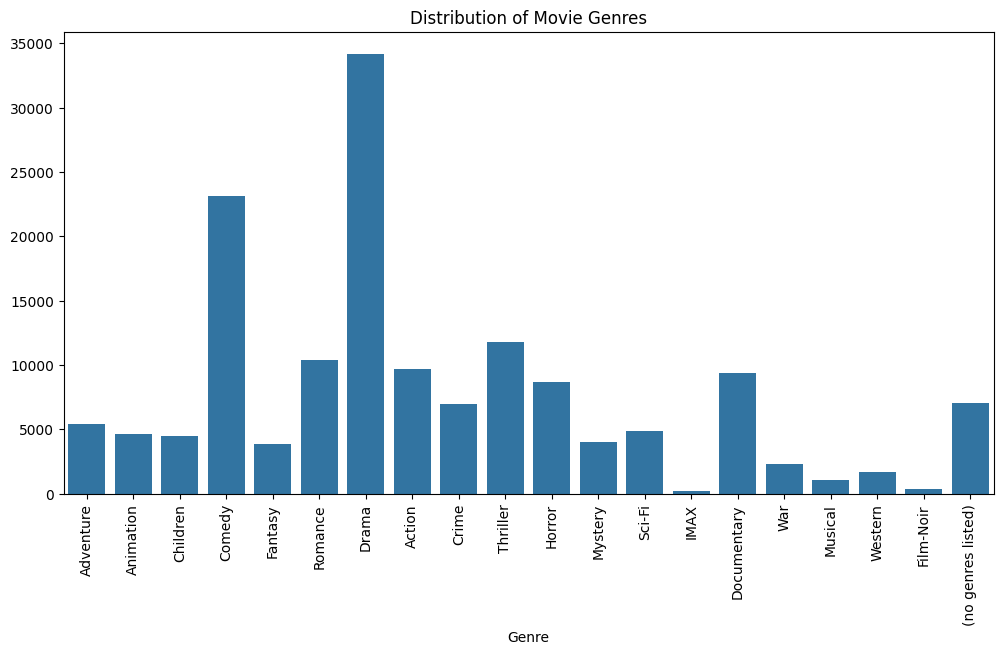

In [ ]:
genre_counts = Counter([genre for sublist in df_movies['genres'].str.split('|') for genre in sublist])
plt.figure(figsize=(12, 6))
sns.barplot(x=list(genre_counts.keys()), y=list(genre_counts.values()))
plt.xticks(rotation=90)
plt.title('Distribution of Movie Genres')
plt.xlabel('Genre')

In [80]:
def extract_year(df_movies):
    df_movies['year'] = df_movies['title'].str.extract(r'\((\d{4})\)').astype(float)
    return df_movies

df_movies = extract_year(df_movies)

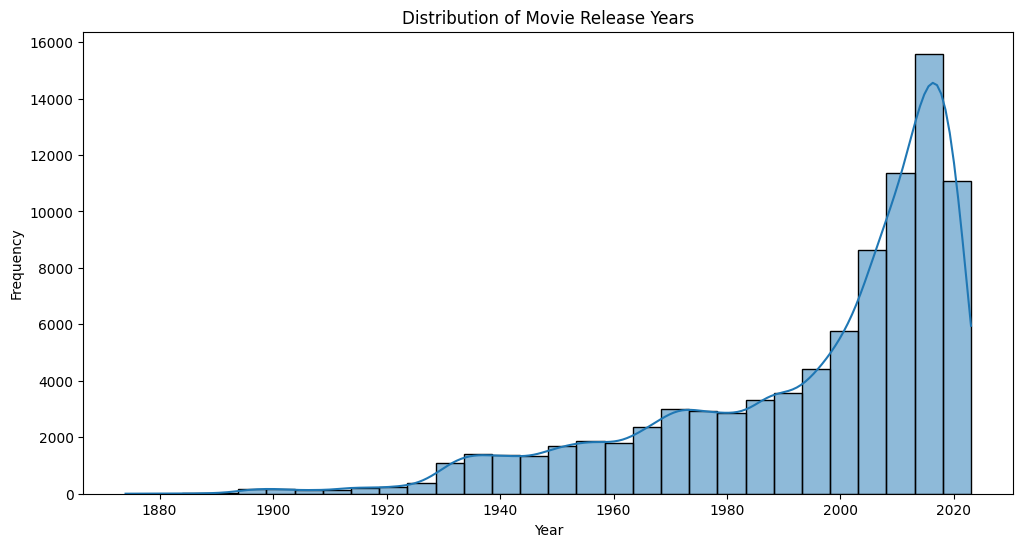

In [81]:
plt.figure(figsize=(12, 6))
sns.histplot(df_movies['year'], bins=30, kde=True)
plt.title('Distribution of Movie Release Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

---
### Ratings Dataset

In [7]:
df_ratings = pd.read_csv("https://huggingface.co/datasets/nasserCha/movielens_ratings_32m/resolve/main/ratings.csv")

In [8]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [9]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000204 entries, 0 to 32000203
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 976.6 MB


In [10]:
df_ratings['rating'].describe()

count    3.200020e+07
mean     3.540396e+00
std      1.058986e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

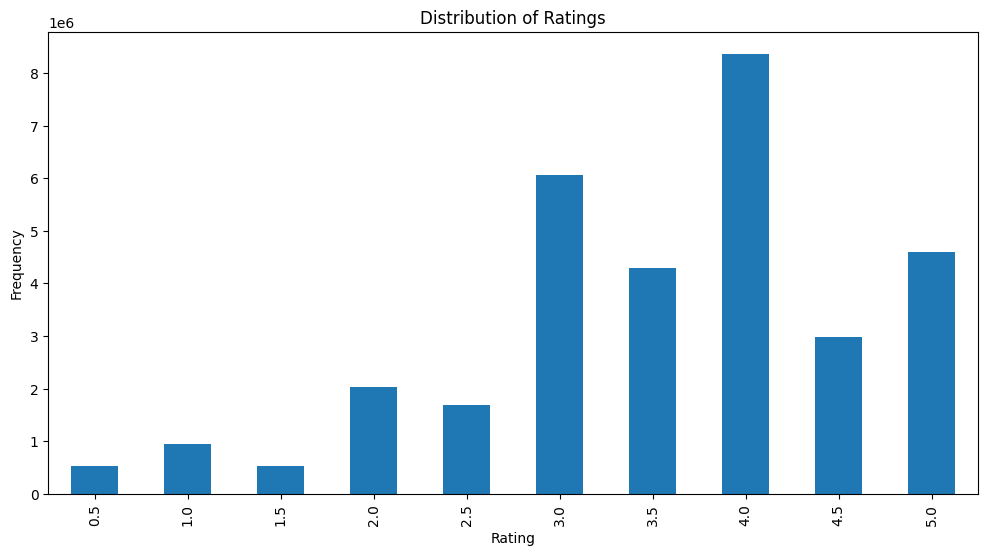

In [ ]:
df_ratings['rating'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6))
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [78]:
top_10_movies = df_ratings.groupby('movieId').size().nlargest(10).index
top_10_movies_df = df_ratings[df_ratings['movieId'].isin(top_10_movies)]
top_10_movies_df = top_10_movies_df.groupby('movieId').agg(
    total_ratings=('rating', 'count'),
    avg_rating=('rating', 'mean')
).reset_index()
top_10_movies_df = top_10_movies_df.merge(df_movies[['movieId', 'title']], on='movieId')
top_10_movies_df = top_10_movies_df.sort_values(by='total_ratings', ascending=False)
top_10_movies_df[['title', 'total_ratings', 'avg_rating']]


,title,total_ratings,avg_rating
2,"Shawshank Redemption, The (1994)",102929,4.404614
3,Forrest Gump (1994),100296,4.052744
1,Pulp Fiction (1994),98409,4.196969
7,"Matrix, The (1999)",93808,4.156437
6,"Silence of the Lambs, The (1991)",90330,4.148367
0,Star Wars: Episode IV - A New Hope (1977),85010,4.099824
8,Fight Club (1999),77332,4.228780
4,Jurassic Park (1993),75233,3.698623
5,Schindler's List (1993),73849,4.236990
9,"Lord of the Rings: The Fellowship of the Ring,...",73122,4.092134


In [77]:
top_10_users = df_ratings.groupby('userId').size().nlargest(10).index
top_10_users_df = df_ratings[df_ratings['userId'].isin(top_10_users)]
top_10_users_df = top_10_users_df.groupby('userId').agg(
    total_ratings=('rating', 'count'),
    avg_rating=('rating', 'mean')
).reset_index()
top_10_users_df = top_10_users_df.sort_values(by='total_ratings', ascending=False)
top_10_users_df

,userId,total_ratings,avg_rating
8,175325,33332,3.077808
2,17035,9577,2.567819
5,55653,9178,3.280290
6,123465,9044,2.528859
7,171795,9016,3.181954
1,10202,7748,3.411655
9,198515,7594,2.822755
4,49305,7488,3.208868
3,22744,7372,2.640193
0,7858,7322,1.549850


---

## Simple Recommendation System

### The Top N Most Popular Movies (Based on Ratings)

This function returns the top **N highest-rated movies** from the dataset, while ensuring each movie has received at least `min_votes` ratings.  
This is important to avoid recommending obscure or unknown movies that may have an artificially high rating from only a few votes.

**Why we use this:**
- It's a simple **baseline recommender** for new users (cold start problem).
- It ensures popularity is backed by **statistical significance** (enough votes).

You can adjust `top_n` to control how many results to return, and `min_votes` to filter out poorly rated or niche content.


In [12]:
def recommend_popular(df_ratings, df_movies, top_n=10, min_votes=50):
    rating_stats = df_ratings.groupby('movieId')['rating'].agg(['mean', 'count']).reset_index()
    rating_stats = rating_stats[rating_stats['count'] >= min_votes]
    top_movies = rating_stats.sort_values('mean', ascending=False).head(top_n)
    return df_movies[df_movies['movieId'].isin(top_movies['movieId'])]['title'].tolist()


In [19]:
top_popular = recommend_popular(df_ratings, df_movies, top_n=10)
print("Top 10 most popular movies (highly rated & widely voted):")
for i, title in enumerate(top_popular, 1):
    print(f"{i}. {title}")

Top 10 most popular movies (highly rated & widely voted):
1. Shawshank Redemption, The (1994)
2. Godfather, The (1972)
3. Planet Earth (2006)
4. Band of Brothers (2001)
5. Planet Earth II (2016)
6. Cosmos
7. Blue Planet II (2017)
8. Twin Peaks (1989)
9. Parasite (2019)
10. Twelve Angry Men (1954)


### Recommend Top Movies by Genre

This function recommends the **top N highest-rated movies within a specific genre**, based on user ratings.

It filters the dataset to include only movies that belong to the selected genre, then applies the `recommend_popular` logic to:
- Ensure each movie has received at least `min_votes` ratings
- Sort by average rating
- Return the top N movie titles

**Why we use this:**
- It allows users to explore the best-rated content in a genre they’re interested in (e.g. Action, Drama, Comedy).
- It's a simple and interpretable way to mix **content-based filtering** with **popularity filtering**.

You can easily adjust `genre`, `top_n`, or `min_votes` to customize the recommendation scope.


In [20]:
def recommend_by_genre(df_movies, df_ratings, genre, top_n=10, min_votes=30):
    filtered_movies = df_movies[df_movies['genres'].str.contains(genre, na=False)]
    filtered_ratings = df_ratings[df_ratings['movieId'].isin(filtered_movies['movieId'])]
    return recommend_popular(filtered_ratings, filtered_movies, top_n=top_n, min_votes=min_votes)

In [22]:
genre = 'Comedy'
top_genre = recommend_by_genre(df_movies, df_ratings, genre=genre, top_n=10)
print(f"Top 10 {genre} Movies:")
for i, title in enumerate(top_genre, 1):
    print(f"{i}. {title}")

Top 10 Comedy Movies:
1. Pulp Fiction (1994)
2. Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
3. Thin Man, The (1934)
4. Monty Python and the Holy Grail (1975)
5. Sting, The (1973)
6. Life Is Beautiful (La Vita è bella) (1997)
7. Pride and Prejudice (1980)
8. It's Such a Beautiful Day (2011)
9. There Once Was a Dog (1982)
10. Parasite (2019)


### Recommend Top Movies by Year

This function returns the **top N highest-rated movies released in a given year**, using a similar approach to `recommend_popular`.

It works by:
- Filtering `df_movies` to keep only movies released in the specified `year`
- Selecting all ratings associated with those movies
- Recommending the most highly-rated ones that meet the `min_votes` threshold

**Why we use this:**
- It lets users explore the best-rated films from a particular year (e.g. best of 1999).
- It combines **temporal filtering** with **rating-based popularity**, making it useful for trend-based or historical exploration.

Parameters like `top_n` and `min_votes` can be adjusted to broaden or narrow the recommendations.


In [82]:
def recommend_by_year(df_movies, df_ratings, year, top_n=10, min_votes=30):
    filtered_movies = df_movies[df_movies['year'] == float(year)]
    filtered_ratings = df_ratings[df_ratings['movieId'].isin(filtered_movies['movieId'])]
    return recommend_popular(filtered_ratings, filtered_movies, top_n=top_n, min_votes=min_votes)


In [83]:
year = 1995
top_year = recommend_by_year(df_movies, df_ratings, year=year, top_n=10)
print(f"Top Movies from {year}:")
for i, title in enumerate(top_year, 1):
    print(f"{i}. {title}")


Top Movies from 1995:
1. Persuasion (1995)
2. Seven (a.k.a. Se7en) (1995)
3. Usual Suspects, The (1995)
4. Antonia's Line (Antonia) (1995)
5. Hate (Haine, La) (1995)
6. Braveheart (1995)
7. Ghost in the Shell (Kôkaku kidôtai) (1995)
8. Wallace & Gromit: A Close Shave (1995)
9. Pride and Prejudice (1995)
10. Whisper of the Heart (Mimi wo sumaseba) (1995)


### Recommend for a New User (Based on Preferred Genres)

This function provides movie recommendations tailored to a **new user** who hasn't rated anything yet, based on their **preferred genres**.

It works by:
- Filtering the movie dataset to include only movies that match at least one of the user’s selected genres
- Reusing the `recommend_popular` logic to sort by average rating and ensure each movie has enough votes

**Why we use this:**
- This is a **cold-start solution** for new users with no rating history
- It provides **personalized but safe** recommendations using content (genres) + popularity (ratings)

You can customize:
- `preferred_genres`: a list like `['Action', 'Comedy']`
- `top_n`: number of recommendations
- `min_votes`: to filter out obscure or low-confidence movies


In [26]:
def recommend_for_new_user(df_movies, df_ratings, preferred_genres, top_n=10, min_votes=20):
    genre_mask = df_movies['genres'].apply(lambda g: any(gen in g for gen in preferred_genres))
    filtered_movies = df_movies[genre_mask]
    filtered_ratings = df_ratings[df_ratings['movieId'].isin(filtered_movies['movieId'])]
    return recommend_popular(filtered_ratings, filtered_movies, top_n=top_n, min_votes=min_votes)


In [28]:
preferred_genres = ['Action', 'Sci-Fi']
cold_recos = recommend_for_new_user(df_movies, df_ratings, preferred_genres=preferred_genres, top_n=10)
print("Recommendations for a new user who likes Action and Sci-Fi:")
for i, title in enumerate(cold_recos, 1):
    print(f"{i}. {title}")


Recommendations for a new user who likes Action and Sci-Fi:
1. North by Northwest (1959)
2. Seven Samurai (Shichinin no samurai) (1954)
3. Fight Club (1999)
4. City of God (Cidade de Deus) (2002)
5. Dark Knight, The (2008)
6. Band of Brothers (2001)
7. The Godfather Family: A Look Inside (1990)
8. Spider-Man: Into the Spider-Verse (2018)
9. Firefly (2002)
10. Spider-Man: Across the Spider-Verse (2023)


---
## Complex Recommender system

### Item-Item Collaborative Filtering (Hybrid)

In this section, we implement a **hybrid item-based recommender system** that combines:

- **Collaborative Filtering**: Based on how users rate different movies
- **Content-Based Filtering**: Based on genre similarity between movies

#### Why use Item-Item CF?
Item-Item CF recommends movies **similar to those the user already liked**, rather than finding similar users. It's:
- More stable (item preferences change less often than user profiles)
- Scalable for large user bases
- Ideal for users with a clear watch history



#### What's happening here?

1. **Genre Preprocessing & Vectorization**:
   - Genres are tokenized using `CountVectorizer` to allow content-based similarity.
   - A genre-based similarity matrix is built using cosine similarity.

2. **Movie-User Rating Matrix**:
   - A sparse matrix is constructed where each row is a movie and each column is a user.
   - This enables rating-based similarity between movies.

3. **`recommend_hybrid(movie_title, alpha)`**:
   - Given a movie title, it finds similar movies using a weighted combination of:
     - Genre similarity
     - Rating similarity (from other users)
   - `alpha` controls the balance (0 = full content, 1 = full collaborative).

4. **`recommend_hybrid_for_user(user_id)`**:
   - For a given user, retrieves movies they liked (e.g., rated ≥ 4).
   - For each liked movie, it retrieves similar movies using `recommend_hybrid`.
   - Aggregates all results and filters out movies already seen.



In [ ]:

df_movies['genres'] = df_movies['genres'].fillna("")

rated_movie_ids = df_ratings['movieId'].unique()
df_common_movies = df_movies[df_movies['movieId'].isin(rated_movie_ids)].reset_index(drop=True)

movie_id_to_index = pd.Series(df_common_movies.index, index=df_common_movies['movieId']).to_dict()
index_to_title = pd.Series(df_common_movies['title'].values, index=df_common_movies.index).to_dict()
title_to_index = pd.Series(df_common_movies.index, index=df_common_movies['title']).to_dict()


vectorizer = CountVectorizer(tokenizer=lambda x: x.split('|'))
genre_matrix_sparse = vectorizer.fit_transform(df_common_movies['genres'])


df_ratings_filtered = df_ratings[df_ratings['movieId'].isin(rated_movie_ids)].copy()
df_ratings_filtered['movie_index'] = df_ratings_filtered['movieId'].map(movie_id_to_index)
df_ratings_filtered['user_index'] = df_ratings_filtered['userId'].astype("category").cat.codes

movie_user_matrix = csr_matrix((
    df_ratings_filtered['rating'],
    (df_ratings_filtered['movie_index'], df_ratings_filtered['user_index'])
))


def recommend_hybrid(movie_title, top_n=5, alpha=0.5):
    if movie_title not in title_to_index:
        return []
    
    idx = title_to_index[movie_title]

    genre_sim = cosine_similarity(genre_matrix_sparse[idx], genre_matrix_sparse).flatten()

    rating_sim = cosine_similarity(movie_user_matrix[idx], movie_user_matrix).flatten()

    combined_score = alpha * rating_sim + (1 - alpha) * genre_sim

    top_indices = combined_score.argsort()[::-1]
    top_indices = [i for i in top_indices if i != idx][:top_n]

    return [index_to_title[i] for i in top_indices]

def recommend_hybrid_for_user(user_id, top_n=10, alpha=0.5, like_threshold=4.0):
    if user_id not in df_ratings['userId'].unique():
        return []

    liked = df_ratings_filtered[
        (df_ratings_filtered['userId'] == user_id) &
        (df_ratings_filtered['rating'] >= like_threshold)
    ]['movie_index'].dropna().unique()

    if len(liked) == 0:
        return []

    all_recos = []
    for idx in liked:
        recos = recommend_hybrid(index_to_title[idx], top_n=top_n, alpha=alpha)
        all_recos.extend(recos)

    reco_counts = Counter(all_recos)

    already_seen = df_ratings_filtered[df_ratings_filtered['userId'] == user_id]['movie_index'].map(index_to_title).dropna().tolist()
    filtered_recos = [title for title, _ in reco_counts.most_common() if title not in already_seen]

    return filtered_recos[:top_n]

c:\Users\Nasse\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [84]:
movie_title = "Toy Story (1995)"
alpha = 0.5
top_n = 10

top_hybrid_item_item_cf = recommend_hybrid(movie_title=movie_title, top_n=10, alpha=alpha)
print(f"Top {top_n} Hybrid Recommendations for '{movie_title}' with alpha = {alpha}:")
for i, title in enumerate(top_hybrid_item_item_cf, 1):
    print(f"{i}. {title}")

Top 10 Hybrid Recommendations for 'Toy Story (1995)' with alpha = 0.5:
1. Toy Story 2 (1999)
2. Monsters, Inc. (2001)
3. Shrek (2001)
4. Finding Nemo (2003)
5. Bug's Life, A (1998)
6. Aladdin (1992)
7. Antz (1998)
8. Toy Story 3 (2010)
9. Emperor's New Groove, The (2000)
10. Incredibles, The (2004)


In [85]:
user_id = 1
top_n = 10
alpha = 0.5

top_hybrid_item_item_cf_for_user = recommend_hybrid_for_user(user_id=user_id, top_n=top_n, alpha=alpha)
print(f"Top {top_n} Hybrid Recommendations for User {user_id} with alpha = {alpha}:")
for i, title in enumerate(top_hybrid_item_item_cf_for_user, 1):
    print(f"{i}. {title}")

Top 10 Hybrid Recommendations for User 1 with alpha = 0.5:
1. Full Metal Jacket (1987)
2. Piano, The (1993)
3. Raising Arizona (1987)
4. To Kill a Mockingbird (1962)
5. Killing Fields, The (1984)
6. Ordinary People (1980)
7. Godfather, The (1972)
8. Heathers (1989)
9. Star Wars: Episode I - The Phantom Menace (1999)
10. Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)



### User-User Collaborative Filtering (Hybrid)

In this section, we implement a **hybrid recommender system** based on **user-to-user similarity**.  
This approach uses both collaborative filtering (rating patterns between users) and content-based signals (genre preferences) to generate personalized movie recommendations.


#### `build_user_user_cf()`
This helper function prepares the core components for collaborative filtering:
- Encodes user and movie IDs as integer indices
- Builds a **sparse user-movie rating matrix** to compute user-to-user similarity
- Returns useful dictionaries for mapping indices back to real user/movie IDs


#### `recommend_user_user_hybrid()`

This is the main hybrid recommender function for users. Here's what it does:

##### Step-by-step:
1. **Genre Vectorization**  
   - Converts the genre column into a binary matrix using `CountVectorizer`, to compare genre preferences.

2. **User Similarity Calculation**  
   - Computes **cosine similarity** between the target user and all others, based on the ratings matrix.
   - Selects the top `k_neighbors` most similar users.

3. **User's Preferred Genres**  
   - Extracts the genres of movies rated above `like_threshold` by the user.
   - Builds a **normalized genre profile** representing the user’s content preferences.

4. **Hybrid Scoring of Candidate Movies**  
   For each film liked by similar users (but unseen by the target user), a **combined score** is computed:
   ```
   combined_score = (1 - genre_weight) * similarity + genre_weight * genre_affinity
   ```
   - `similarity`: how close the neighbor is to the user (based on ratings)
   - `genre_affinity`: how well the movie matches the user’s genre profile
   - `genre_weight`: controls the tradeoff between behavioral and content similarity

5. **Final Recommendation**  
   - Returns the top `N` unseen movies with the highest hybrid scores


#### Why use this?
- Works well for users with rating history (learns from similar people)
- Includes **genre-awareness** to avoid recommending off-topic content
- Helps balance **personalization** and **content alignment**


In [ ]:
def build_user_user_cf(df_ratings):
    df_ratings['user_index'] = df_ratings['userId'].astype("category").cat.codes
    df_ratings['movie_index'] = df_ratings['movieId'].astype("category").cat.codes

    user_index_to_id = dict(enumerate(df_ratings['userId'].astype("category").cat.categories))
    movie_index_to_id = dict(enumerate(df_ratings['movieId'].astype("category").cat.categories))

    user_movie_matrix = csr_matrix((
        df_ratings['rating'],
        (df_ratings['user_index'], df_ratings['movie_index'])
    ))

    return user_movie_matrix, user_index_to_id, movie_index_to_id, df_ratings




def recommend_user_user_hybrid(user_id, df_ratings, df_movies, top_n=10, like_threshold=4.0, k_neighbors=5, genre_weight=0.3):
    df_movies = df_movies.copy()
    df_movies['genres'] = df_movies['genres'].fillna("")

    vectorizer = CountVectorizer(tokenizer=lambda x: x.split('|'))
    genre_matrix = vectorizer.fit_transform(df_movies['genres'])
    genre_df = pd.DataFrame(genre_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    df_movies = pd.concat([df_movies, genre_df], axis=1)

    user_movie_matrix, user_index_to_id, movie_index_to_id, df_ratings = build_user_user_cf(df_ratings)

    if user_id not in df_ratings['userId'].values:
        return []

    user_id_to_index = {v: k for k, v in user_index_to_id.items()}
    user_idx = user_id_to_index[user_id]

    sim_vector = cosine_similarity(user_movie_matrix[user_idx], user_movie_matrix).flatten()
    similar_users_idx = np.argsort(sim_vector)[::-1]
    similar_users_idx = [i for i in similar_users_idx if i != user_idx][:k_neighbors]

    liked_movies = df_ratings[(df_ratings['userId'] == user_id) & (df_ratings['rating'] >= like_threshold)]
    liked_movie_ids = liked_movies['movieId'].unique()
    liked_genres = df_movies[df_movies['movieId'].isin(liked_movie_ids)][genre_df.columns].sum()
    liked_genres = liked_genres / liked_genres.sum()  

    
    seen_movie_ids = df_ratings[df_ratings['userId'] == user_id]['movieId'].unique()
    score_dict = defaultdict(float)

   
    for neighbor_idx in similar_users_idx:
        neighbor_id = user_index_to_id[neighbor_idx]
        similarity = sim_vector[neighbor_idx]

        neighbor_likes = df_ratings[
            (df_ratings['userId'] == neighbor_id) &
            (df_ratings['rating'] >= like_threshold)
        ]

        for _, row in neighbor_likes.iterrows():
            movie_id = row['movieId']
            if movie_id in seen_movie_ids:
                continue

            movie_row = df_movies[df_movies['movieId'] == movie_id]
            if movie_row.empty:
                continue
            movie_genres = movie_row[genre_df.columns].values.flatten()
            genre_affinity = np.dot(movie_genres, liked_genres.values)  

            
            combined_score = (1 - genre_weight) * similarity + genre_weight * genre_affinity
            score_dict[movie_id] += combined_score


    recommended_movie_ids = sorted(score_dict, key=score_dict.get, reverse=True)[:top_n]
    titles = df_movies[df_movies['movieId'].isin(recommended_movie_ids)]['title'].tolist()

    return titles

In [67]:
user_id = 3
genre_weight = 1
top_n = 10

top_movie_for_user_hybrid = recommend_user_user_hybrid(user_id=user_id, df_ratings=df_ratings, df_movies=df_movies, top_n=top_n, genre_weight=genre_weight)
print(f"Top {top_n} Recommendations for User {user_id} (User-User CF) with genre weight={genre_weight}:")
for i, title in enumerate(top_movie_for_user_hybrid, 1):
    print(f"{i}. {title}")


Top 10 Recommendations for User 3 (User-User CF) with genre weight=1:
1. Toy Story (1995)
2. Ghost (1990)
3. Snow White and the Seven Dwarfs (1937)
4. E.T. the Extra-Terrestrial (1982)
5. Sneakers (1992)
6. Mulan (1998)
7. Left Behind: The Movie (2000)
8. Planet of the Apes (2001)
9. Musketeer, The (2001)
10. King Solomon's Mines (1937)


---
## Manual Comparison: Recommendations for a Specific User

To get an intuitive sense of how each hybrid recommender system performs, we manually inspect the top 10 recommendations for a specific user (`user_id = 42`). This example helps visualize the difference in recommendation strategies between the **User-User Hybrid** and the **Item-Item Hybrid** approaches.

The goal here is to qualitatively assess the coherence, diversity, and relevance of the results returned by each model.



In [96]:
user_id = 42
top_n = 10

top_user_user_example = recommend_user_user_hybrid(user_id=user_id, df_ratings=df_ratings, df_movies=df_movies, top_n=top_n)
print(f"Top {top_n} Recommendations for User {user_id} (User-User Hybrid):")
for i, title in enumerate(top_user_user_example, 1):
    print(f"{i}. {title}")

print("\n" + "="*50 + "\n")

top_item_item_example = recommend_hybrid_for_user(user_id=user_id, top_n=top_n)
print(f"Top {top_n} Recommendations for User {user_id} (Item-Item Hybrid):")
for i, title in enumerate(top_item_item_example, 1):
    print(f"{i}. {title}")

c:\Users\Nasse\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Top 10 Recommendations for User 42 (User-User Hybrid):
1. Braveheart (1995)
2. Forrest Gump (1994)
3. Jurassic Park (1993)
4. Rear Window (1954)
5. E.T. the Extra-Terrestrial (1982)
6. Alien (1979)
7. Chinatown (1974)
8. Great Escape, The (1963)
9. Gandhi (1982)
10. Star Trek VI: The Undiscovered Country (1991)


Top 10 Recommendations for User 42 (Item-Item Hybrid):
1. Jurassic Park (1993)
2. Star Trek: Generations (1994)
3. Twister (1996)
4. Hunt for Red October, The (1990)
5. Killing Fields, The (1984)
6. Total Recall (1990)
7. Abyss, The (1989)
8. Stand by Me (1986)
9. Firm, The (1993)
10. Speed (1994)


### Interpretation of the Hybrid Recommendations

The recommendations generated by the two hybrid systems—**User-User Hybrid** and **Item-Item Hybrid**—are highly consistent with the expected behavior of each model.

- The **User-User Hybrid** model returned a list of diverse, critically acclaimed films across multiple genres (e.g., *Braveheart*, *Forrest Gump*, *Gandhi*, *Alien*, *Rear Window*). This reflects the influence of similar users' preferences and showcases a more **cinéphile-oriented profile**, where recommendations span various eras and styles.

- The **Item-Item Hybrid** model produced recommendations that were more **stylistically consistent**, leaning towards mainstream action, sci-fi, and thriller films (e.g., *Jurassic Park*, *Twister*, *Total Recall*, *Speed*). These results indicate the model’s ability to identify **content-level or rating-based similarities** between movies, regardless of broader user diversity.

This contrast demonstrates how the two models complement each other:  
one captures **user taste diversity**, while the other ensures **genre coherence and item similarity**. Both models behave as expected and reinforce the robustness of the hybrid recommendation approach.